In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('diabetes_prediction_dataset.csv')

df['smoking_history'] = df['smoking_history'].replace('ever', 'never')
# Fixing the 'ever' value to 'never' for consistency
df['smoking_history'] = df['smoking_history'].replace('not current', 'former')
# Fixing the 'not current' value to 'former' for consistency

df.replace('No Info', np.nan, inplace=True)
#Replacing 'No Info' with NaN for better handling of missing values


df = pd.get_dummies(df, columns=['smoking_history'], dummy_na=False)
#One-hot encoding the 'smoking_history' column

df = pd.get_dummies(df, columns=['gender'], drop_first=True)

df['bmi_was_27_32'] = (df['bmi'] == 27.32).astype(int)

# Assuming df is already loaded and cleaned
# Make sure your target column is named 'diabetes' or adjust accordingly

#df['combined1']=df['HbA1c_level']**1.5 * df['blood_glucose_level'] 
#df['combined2']=df['bmi'] * df['age']**1.5 

# Data preparation

In [18]:
print(df.isnull().sum())

age                        0
hypertension               0
heart_disease              0
bmi                        0
HbA1c_level                0
blood_glucose_level        0
diabetes                   0
smoking_history_current    0
smoking_history_former     0
smoking_history_never      0
gender_Male                0
gender_Other               0
bmi_was_27_32              0
dtype: int64


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linea


Best Threshold for F1 (Class 1): 0.875
Classification Report (F1-Optimized for Class 1):
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     18292
           1       0.80      0.66      0.73      1708

    accuracy                           0.96     20000
   macro avg       0.88      0.82      0.85     20000
weighted avg       0.95      0.96      0.96     20000

AUC: 0.9620310301889053
Confusion Matrix:
 [[18007   285]
 [  574  1134]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


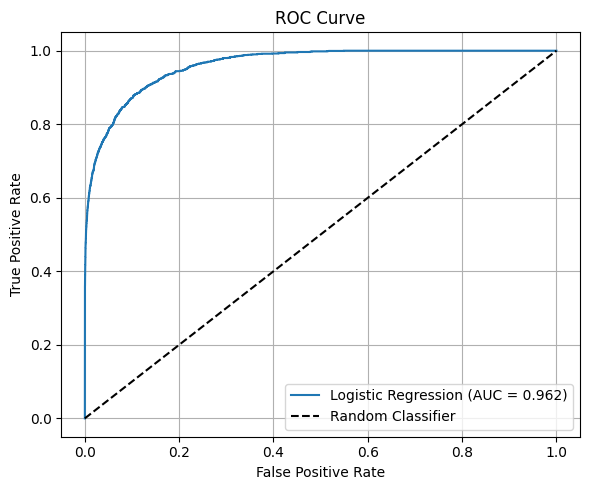

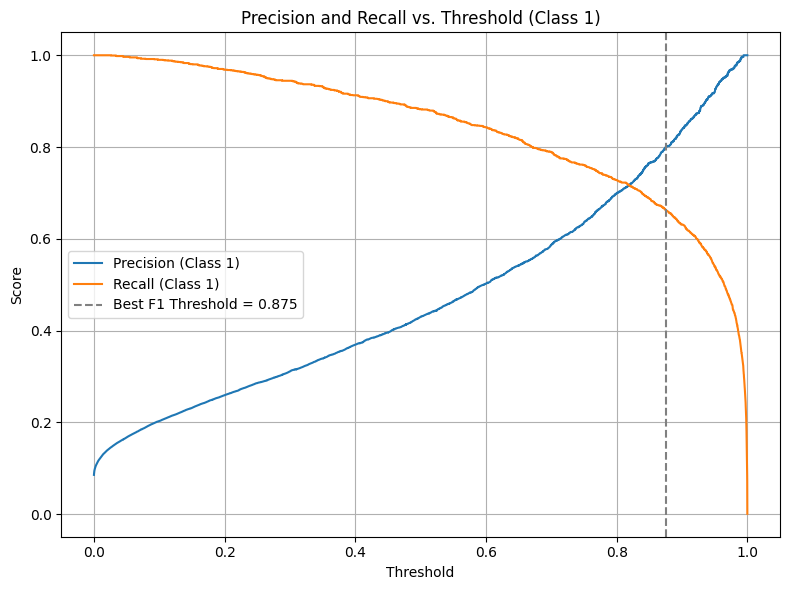

PR-AUC: 0.812


In [ ]:
X = df.drop(columns='diabetes')
y = df['diabetes']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression with class_weight='balanced'
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Predict probabilities for class 1
y_proba = model.predict_proba(X_test)[:, 1]

# Precision, recall, thresholds for class 1
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for each threshold (class 1–focused)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

# Best threshold that maximizes F1 for class 1
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
y_pred = (y_proba >= best_thresh).astype(int)

# Evaluation
print(f"\nBest Threshold for F1 (Class 1): {best_thresh:.3f}")
print("Classification Report (F1-Optimized for Class 1):\n", classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision, Recall vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision (Class 1)')
plt.plot(thresholds, recall[:-1], label='Recall (Class 1)')
plt.axvline(best_thresh, color='gray', linestyle='--', label=f'Best F1 Threshold = {best_thresh:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold (Class 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import average_precision_score

# y_test = true labels
# y_proba = predicted probabilities for the positive class

pr_auc = average_precision_score(y_test, y_proba)
print(f"PR-AUC: {pr_auc:.3f}")

Depending on the applications, we may want to ensure that recall is as close to one as possible to catch almost all diabetes cases.
This would result in a low precision, meaning many false positives. But in such cases, further testing can be done to confirm classification.
It is near impossible to get a high recall and high precision score with data at one timestamp. 